# **Model Implementation 1**

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.utils import make_grid
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, jaccard_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
# Parameters
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 50
VAL_SPLIT = 0.2
IMAGE_SIZE = (256, 256)
NUM_CLASSES = 3  # Background, Pet, Border
USE_PRETRAINED = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = './data'
MODEL_PATH = './unet_pet_model.pth'


In [3]:
class ImageTransform:
    def __init__(self, image_size):
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

    def __call__(self, img):
        return self.transform(img)

class MaskTransform:
    def __init__(self, image_size):
        self.transform = transforms.Compose([
            transforms.Resize(image_size, interpolation=Image.NEAREST),
            transforms.PILToTensor()
        ])

    def __call__(self, mask):
        mask = self.transform(mask).squeeze(0)  # [H, W]
        mask = mask.long()
        mask = mask - 1  # from [1, 2, 3] to [0, 1, 2]
        return torch.clamp(mask, 0, 2)


In [4]:
image_transform = ImageTransform(IMAGE_SIZE)
mask_transform = MaskTransform(IMAGE_SIZE)

dataset = OxfordIIITPet(
    root=DATA_DIR,
    split='trainval',
    target_types='segmentation',
    download=False,
    transform=image_transform,
    target_transform=mask_transform
)


In [5]:
for root, dirs, files in os.walk(os.path.join(DATA_DIR, 'oxford-iiit-pet')):
    level = root.replace(DATA_DIR, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files[:3]:
        print(f'{subindent}{f}')


    oxford-iiit-pet/
        annotations.tar.gz
        images.tar.gz
        annotations/
            ._trimaps
            list.txt
            trainval.txt
            xmls/
                chihuahua_173.xml
                leonberger_113.xml
                Persian_144.xml
            trimaps/
                Siamese_95.png
                great_pyrenees_99.png
                miniature_pinscher_6.png
        images/
            american_pit_bull_terrier_99.jpg
            Russian_Blue_211.jpg
            scottish_terrier_105.jpg


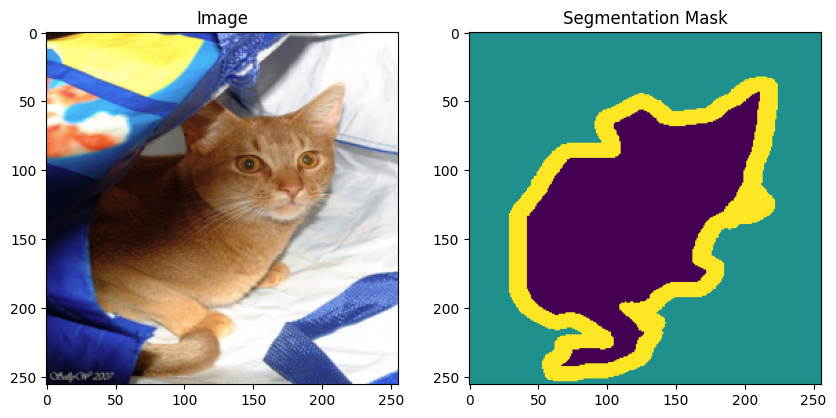

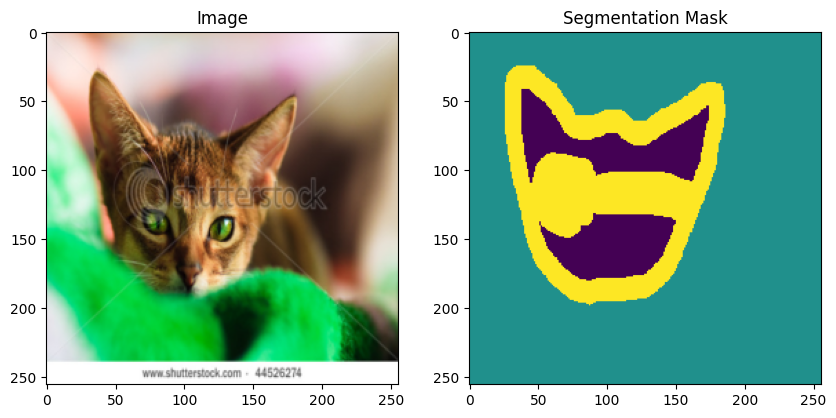

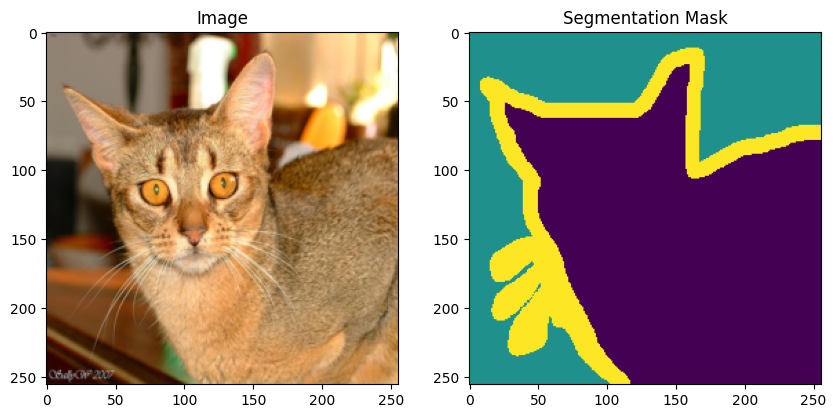

In [6]:
def show_sample(index):
    image, mask = dataset[index]
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image.permute(1, 2, 0))
    axs[0].set_title("Image")
    axs[1].imshow(mask)
    axs[1].set_title("Segmentation Mask")
    plt.show()

for i in range(3):
    show_sample(i)


In [7]:
val_size = int(len(dataset) * VAL_SPLIT)
train_size = len(dataset) - val_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)


In [8]:
class UNet(nn.Module):
    def __init__(self, num_classes, use_pretrained=False):
        super().__init__()
        if use_pretrained:
            base_model = models.resnet34(pretrained=True)
            self.base_layers = nn.Sequential(*list(base_model.children())[:-2])
            self.encoder_channels = 512
        else:
            self.base_layers = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )
            self.encoder_channels = 64

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.encoder_channels, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1),
            nn.Upsample(size=IMAGE_SIZE, mode='bilinear', align_corners=False)  # Ensure output is 256x256
        )

    def forward(self, x):
        x = self.base_layers(x)
        x = self.decoder(x)
        return x


In [9]:
model = UNet(num_classes=NUM_CLASSES, use_pretrained=USE_PRETRAINED).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

print(model)
print(f"Optimizer: {optimizer}")
print(f"Loss Function: {criterion}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


UNet(
  (base_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [10]:
train_losses = []
val_losses = []
val_accuracies = []

def calculate_accuracy(preds, labels):
    return (preds == labels).float().mean().item()

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    epoch_train_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    epoch_val_loss = 0
    epoch_val_acc = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            epoch_val_acc += calculate_accuracy(preds, masks)

    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_val_acc = epoch_val_acc / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] ➤ Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")


Epoch 1/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.52it/s]


Epoch [1/50] ➤ Train Loss: 0.4464 | Val Loss: 0.2698 | Val Acc: 0.8951


Epoch 2/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.61it/s]


Epoch [2/50] ➤ Train Loss: 0.2408 | Val Loss: 0.2303 | Val Acc: 0.9099


Epoch 3/50 - Validation: 100%|██████████| 184/184 [00:07<00:00, 25.18it/s]


Epoch [3/50] ➤ Train Loss: 0.1999 | Val Loss: 0.2262 | Val Acc: 0.9118


Epoch 4/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 28.34it/s]


Epoch [4/50] ➤ Train Loss: 0.1765 | Val Loss: 0.2227 | Val Acc: 0.9147


Epoch 5/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.15it/s]


Epoch [5/50] ➤ Train Loss: 0.1673 | Val Loss: 0.2449 | Val Acc: 0.9079


Epoch 6/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.30it/s]


Epoch [6/50] ➤ Train Loss: 0.1582 | Val Loss: 0.2422 | Val Acc: 0.9077


Epoch 7/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.56it/s]


Epoch [7/50] ➤ Train Loss: 0.1427 | Val Loss: 0.2148 | Val Acc: 0.9197


Epoch 8/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.61it/s]


Epoch [8/50] ➤ Train Loss: 0.1291 | Val Loss: 0.2297 | Val Acc: 0.9175


Epoch 9/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.29it/s]


Epoch [9/50] ➤ Train Loss: 0.1273 | Val Loss: 0.2181 | Val Acc: 0.9210


Epoch 10/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 27.14it/s]


Epoch [10/50] ➤ Train Loss: 0.1152 | Val Loss: 0.2612 | Val Acc: 0.9123


Epoch 11/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 28.13it/s]


Epoch [11/50] ➤ Train Loss: 0.1445 | Val Loss: 0.2218 | Val Acc: 0.9203


Epoch 12/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.43it/s]


Epoch [12/50] ➤ Train Loss: 0.1072 | Val Loss: 0.2232 | Val Acc: 0.9237


Epoch 13/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.42it/s]


Epoch [13/50] ➤ Train Loss: 0.0945 | Val Loss: 0.2288 | Val Acc: 0.9233


Epoch 14/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.41it/s]


Epoch [14/50] ➤ Train Loss: 0.0896 | Val Loss: 0.2351 | Val Acc: 0.9237


Epoch 15/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 27.22it/s]


Epoch [15/50] ➤ Train Loss: 0.0855 | Val Loss: 0.2539 | Val Acc: 0.9215


Epoch 16/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.73it/s]


Epoch [16/50] ➤ Train Loss: 0.1200 | Val Loss: 0.2437 | Val Acc: 0.9173


Epoch 17/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.56it/s]


Epoch [17/50] ➤ Train Loss: 0.0863 | Val Loss: 0.2405 | Val Acc: 0.9239


Epoch 18/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.80it/s]


Epoch [18/50] ➤ Train Loss: 0.0751 | Val Loss: 0.2483 | Val Acc: 0.9247


Epoch 19/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.86it/s]


Epoch [19/50] ➤ Train Loss: 0.0704 | Val Loss: 0.2626 | Val Acc: 0.9233


Epoch 20/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 27.42it/s]


Epoch [20/50] ➤ Train Loss: 0.0691 | Val Loss: 0.2607 | Val Acc: 0.9248


Epoch 21/50 - Validation: 100%|██████████| 184/184 [00:07<00:00, 26.26it/s]


Epoch [21/50] ➤ Train Loss: 0.0946 | Val Loss: 0.2494 | Val Acc: 0.9099


Epoch 22/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 28.83it/s]


Epoch [22/50] ➤ Train Loss: 0.0949 | Val Loss: 0.2387 | Val Acc: 0.9192


Epoch 23/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.87it/s]


Epoch [23/50] ➤ Train Loss: 0.0717 | Val Loss: 0.2604 | Val Acc: 0.9246


Epoch 24/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.67it/s]


Epoch [24/50] ➤ Train Loss: 0.0607 | Val Loss: 0.2733 | Val Acc: 0.9249


Epoch 25/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.88it/s]


Epoch [25/50] ➤ Train Loss: 0.0582 | Val Loss: 0.2929 | Val Acc: 0.9244


Epoch 26/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.43it/s]


Epoch [26/50] ➤ Train Loss: 0.0577 | Val Loss: 0.2916 | Val Acc: 0.9242


Epoch 27/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.62it/s]


Epoch [27/50] ➤ Train Loss: 0.0578 | Val Loss: 0.2871 | Val Acc: 0.9249


Epoch 28/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.89it/s]


Epoch [28/50] ➤ Train Loss: 0.0573 | Val Loss: 0.2950 | Val Acc: 0.9242


Epoch 29/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.40it/s]


Epoch [29/50] ➤ Train Loss: 0.0561 | Val Loss: 0.3051 | Val Acc: 0.9242


Epoch 30/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 27.23it/s]


Epoch [30/50] ➤ Train Loss: 0.0548 | Val Loss: 0.3020 | Val Acc: 0.9247


Epoch 31/50 - Validation: 100%|██████████| 184/184 [00:07<00:00, 26.24it/s]


Epoch [31/50] ➤ Train Loss: 0.0749 | Val Loss: 0.2742 | Val Acc: 0.9217


Epoch 32/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.66it/s]


Epoch [32/50] ➤ Train Loss: 0.0566 | Val Loss: 0.3044 | Val Acc: 0.9243


Epoch 33/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.76it/s]


Epoch [33/50] ➤ Train Loss: 0.0548 | Val Loss: 0.3177 | Val Acc: 0.9249


Epoch 34/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.19it/s]


Epoch [34/50] ➤ Train Loss: 0.0472 | Val Loss: 0.3254 | Val Acc: 0.9251


Epoch 35/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.86it/s]


Epoch [35/50] ➤ Train Loss: 0.0453 | Val Loss: 0.3337 | Val Acc: 0.9255


Epoch 36/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.85it/s]


Epoch [36/50] ➤ Train Loss: 0.0458 | Val Loss: 0.3246 | Val Acc: 0.9261


Epoch 37/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.71it/s]


Epoch [37/50] ➤ Train Loss: 0.0460 | Val Loss: 0.3349 | Val Acc: 0.9254


Epoch 38/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.54it/s]


Epoch [38/50] ➤ Train Loss: 0.0468 | Val Loss: 0.3372 | Val Acc: 0.9254


Epoch 39/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.66it/s]


Epoch [39/50] ➤ Train Loss: 0.0453 | Val Loss: 0.3385 | Val Acc: 0.9255


Epoch 40/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 27.36it/s]


Epoch [40/50] ➤ Train Loss: 0.0441 | Val Loss: 0.3466 | Val Acc: 0.9263


Epoch 41/50 - Validation: 100%|██████████| 184/184 [00:07<00:00, 26.16it/s]


Epoch [41/50] ➤ Train Loss: 0.0435 | Val Loss: 0.3565 | Val Acc: 0.9256


Epoch 42/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.92it/s]


Epoch [42/50] ➤ Train Loss: 0.0432 | Val Loss: 0.3774 | Val Acc: 0.9217


Epoch 43/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.77it/s]


Epoch [43/50] ➤ Train Loss: 0.0842 | Val Loss: 0.2839 | Val Acc: 0.9208


Epoch 44/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.33it/s]


Epoch [44/50] ➤ Train Loss: 0.0467 | Val Loss: 0.3212 | Val Acc: 0.9249


Epoch 45/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.06it/s]


Epoch [45/50] ➤ Train Loss: 0.0381 | Val Loss: 0.3525 | Val Acc: 0.9257


Epoch 46/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.53it/s]


Epoch [46/50] ➤ Train Loss: 0.0358 | Val Loss: 0.3653 | Val Acc: 0.9254


Epoch 47/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.67it/s]


Epoch [47/50] ➤ Train Loss: 0.0360 | Val Loss: 0.3725 | Val Acc: 0.9252


Epoch 48/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 26.83it/s]


Epoch [48/50] ➤ Train Loss: 0.0366 | Val Loss: 0.3653 | Val Acc: 0.9258


Epoch 49/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 27.69it/s]


Epoch [49/50] ➤ Train Loss: 0.0375 | Val Loss: 0.3625 | Val Acc: 0.9254


Epoch 50/50 - Validation: 100%|██████████| 184/184 [00:06<00:00, 29.81it/s]

Epoch [50/50] ➤ Train Loss: 0.0397 | Val Loss: 0.3565 | Val Acc: 0.9254


In [11]:
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to ./unet_pet_model.pth


In [12]:
model_loaded = UNet(num_classes=NUM_CLASSES, use_pretrained=USE_PRETRAINED).to(DEVICE)
model_loaded.load_state_dict(torch.load(MODEL_PATH))
model_loaded.eval()
print("Model loaded.")


Model loaded.


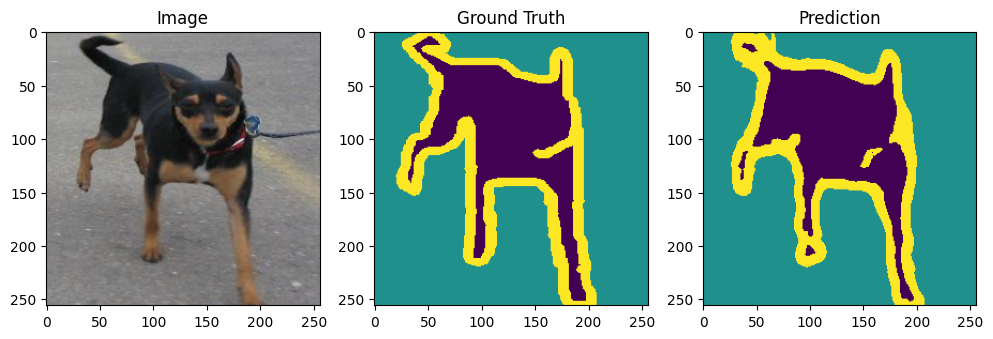

In [13]:
def predict_and_show(model, dataset, index):
    model.eval()
    image, mask = dataset[index]
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(DEVICE)
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image.permute(1, 2, 0))
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Ground Truth')
    axs[2].imshow(pred)
    axs[2].set_title('Prediction')
    plt.show()

predict_and_show(model_loaded, val_data, 0)


In [14]:
def compute_metrics(model, loader, num_classes=3):
    from sklearn.metrics import accuracy_score, jaccard_score, f1_score

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy().flatten())
            all_targets.append(masks.cpu().numpy().flatten())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)

    acc = accuracy_score


In [22]:
def evaluate_metrics(model, dataloader, num_classes=3):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy().flatten())
            all_targets.append(masks.cpu().numpy().flatten())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)

    # Pixel Accuracy
    pixel_accuracy = accuracy_score(y_true, y_pred)

    # Per-Class IoU & Dice
    iou = jaccard_score(y_true, y_pred, average=None, labels=list(range(num_classes)))
    mean_iou = jaccard_score(y_true, y_pred, average='macro')

    dice = f1_score(y_true, y_pred, average=None, labels=list(range(num_classes)))
    mean_dice = f1_score(y_true, y_pred, average='macro')

    print("\n📊 Segmentation Performance Metrics:")
    print(f"Pixel Accuracy     : {pixel_accuracy:.4f}")
    print(f"Mean IoU           : {mean_iou:.4f}")
    print(f"Mean Dice Score    : {mean_dice:.4f}")
    print("Per-Class IoU      :", np.round(iou, 4))
    print("Per-Class Dice     :", np.round(dice, 4))

    return y_true, y_pred


In [23]:
def plot_confusion(y_true, y_pred, num_classes=3):
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Bg', 'Pet', 'Outline'], yticklabels=['Bg', 'Pet', 'Outline'])
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


Evaluating: 100%|██████████| 184/184 [00:08<00:00, 21.10it/s]



📊 Segmentation Performance Metrics:
Pixel Accuracy     : 0.9254
Mean IoU           : 0.7830
Mean Dice Score    : 0.8672
Per-Class IoU      : [0.8741 0.9314 0.5434]
Per-Class Dice     : [0.9328 0.9645 0.7042]


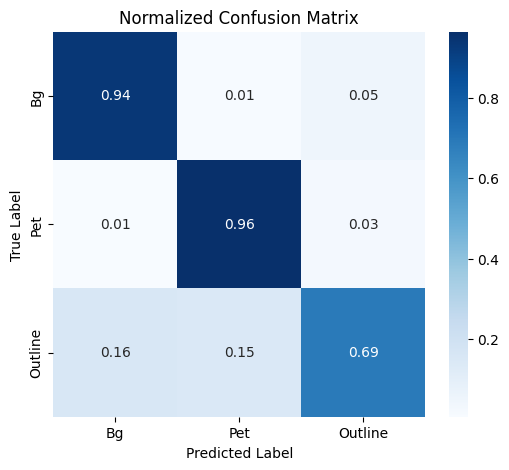

In [24]:
y_true, y_pred = evaluate_metrics(model_loaded, val_loader, num_classes=NUM_CLASSES)
plot_confusion(y_true, y_pred, num_classes=NUM_CLASSES)


In [25]:
def plot_training_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o', color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


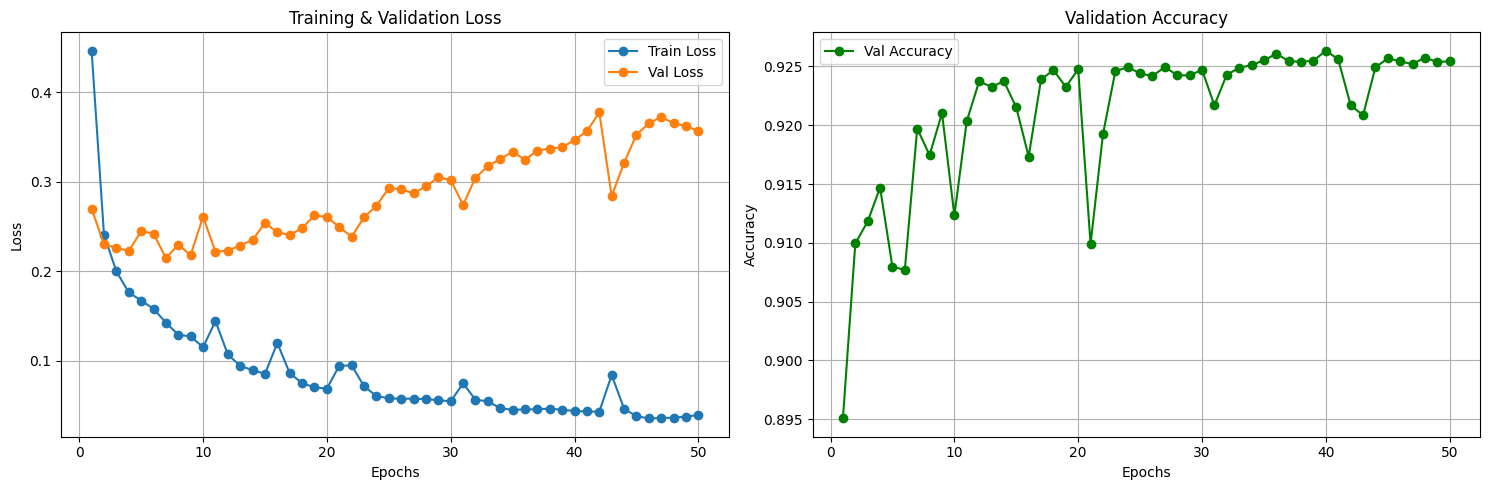

In [26]:
plot_training_curves(train_losses, val_losses, val_accuracies)


In [ ]:
#Please give me same code on differetn dataset like (rather than Oxford and VOC) and also used another base model (rather than "resnet34")

In [27]:
from PIL import Image

def predict_image(image_path, model, transform, class_labels=None):
    model.eval()

    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)  # Add batch dim

    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Plot input and prediction
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='jet')
    if class_labels:
        plt.title("Predicted Mask\n" + ", ".join(f"{i}: {name}" for i, name in enumerate(class_labels)))
    else:
        plt.title("Predicted Mask")
    plt.colorbar()
    plt.show()


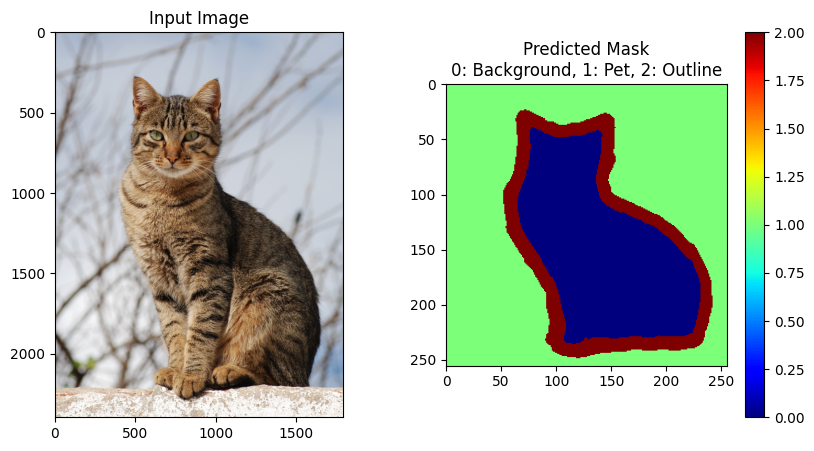

In [28]:
# Path to any image (same type as dataset — a pet image)
test_image_path = "/content/test.jpg"

# Use the same transform as during training
image_transform = ImageTransform(IMAGE_SIZE)

# Call the prediction function
predict_image(test_image_path, model_loaded, image_transform, class_labels=['Background', 'Pet', 'Outline'])
